In [18]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

import re

# 20newsgroups categories used to filter the dataset
categories = [
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'alt.atheism',
 'soc.religion.christian',
]

dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, remove=('headers', 'footers', 'quotes'))

df = pd.DataFrame(dataset.data, columns=["corpus"]).sample(10) # <-- we only take
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,corpus
2401,"\n: In any case, I think Viola would have made..."
2449,\n\nGood question. I'm sure some biologist co...
2322,"\n\n AH! But what, exactly, is ""inherentl..."
1647,boards injuring his shoulder and they blotted ...
1072,\n\n\nWhy should I keep my fingers crossed? I ...


In [9]:
def preprocess_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text


def get_sentiment(text: str):
  """
  Function that uses NLTK.Vader to extract sentiment.
  Sentiment is a score that expresses how positive or negative a text is.
  The value ranges from -1 to 1, where 1 is the most positive value.
  Args:
       text (str): text to parse
  Returns:
       sentiment (float): polarity of the text
   """
  vader = SentimentIntensityAnalyzer()
  return vader.polarity_scores(text)['compound']

def get_nchars(text: str):
  """
  Function that returns the number of characters in a text.
  Args:
       text (str): text to parse
  Returns:
       n_chars (int): number of characters
  """
  return len(text)

def get_nsentences(text: str):
  """
  Function that returns the number of sentences in a text.
  Args:
       text (str): text to parse
  Returns:
       n_chars (int): number of sentences
  """
  return len(text.split("."))

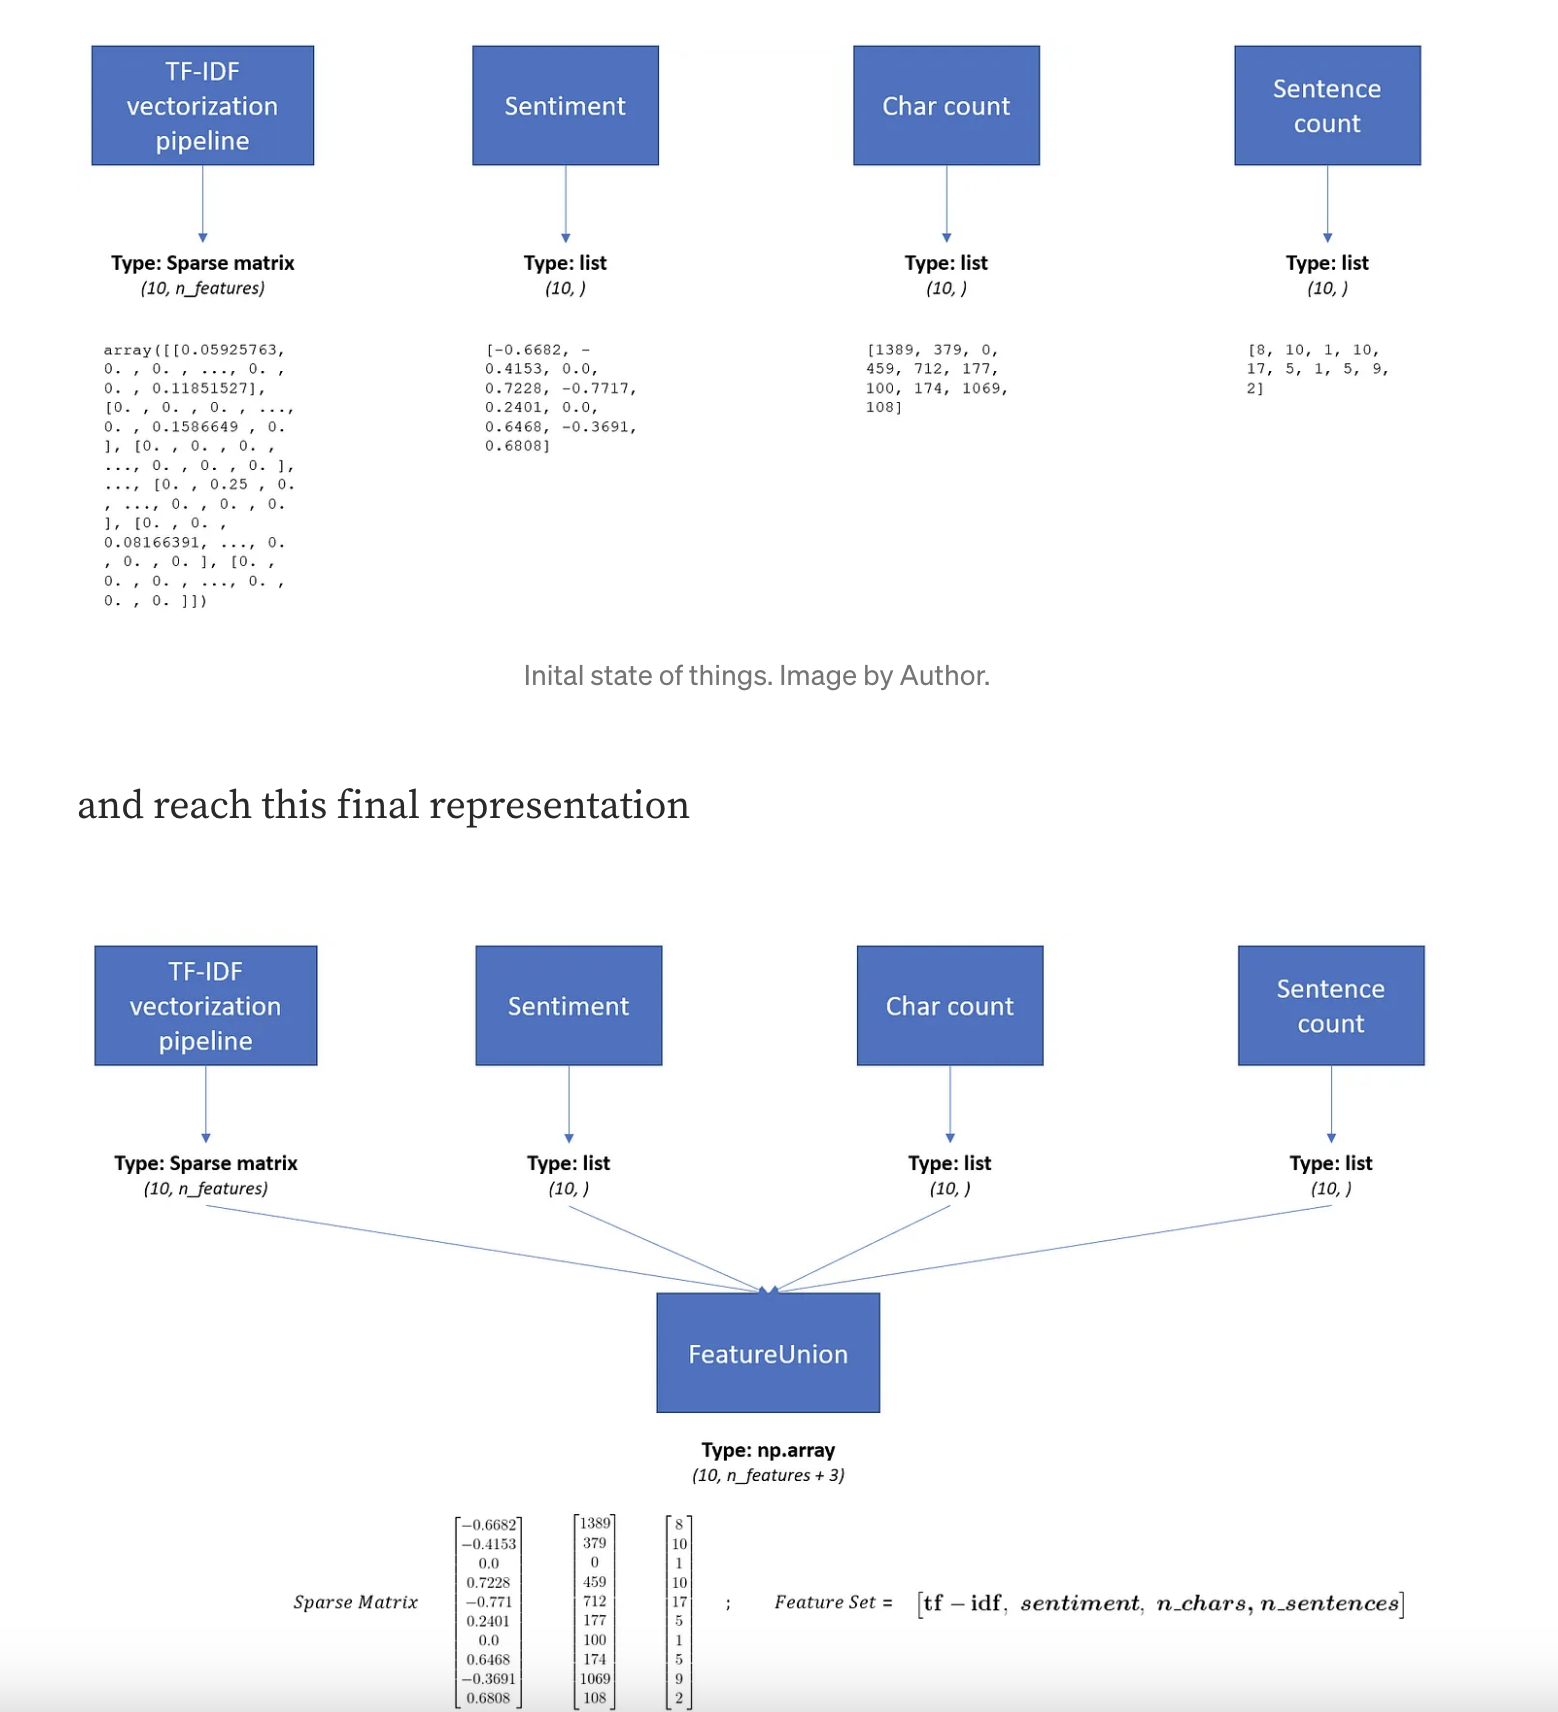

Classes that Inherit from BaseEstimator and TransformerMixin
In order to get our process going, we need to define the classes and what they will do in the pipeline. Let’s start by creating a DummyEstimator, from which we will inherit init, fit and transform. The DummyEstimator is a handy class that saves us from writing redundant code.

In [10]:
class DummyTransformer(BaseEstimator, TransformerMixin):
  """
  Dummy class that allows us to modify only the methods that interest us,
  avoiding redudancy.
  """
  def __init__(self):
    return None

  def fit(self, X=None, y=None):
    return self

  def transform(self, X=None):
    return self

In [11]:
class Preprocessor(DummyTransformer):
  """
  Class used to preprocess text
  """
  def __init__(self, remove_stopwords: bool):
    self.remove_stopwords = remove_stopwords
    return None

  def transform(self, X=None):
    preprocessed = X.apply(lambda x: preprocess_text(x, self.remove_stopwords)).values
    return preprocessed

class SentimentAnalysis(DummyTransformer):
  """
  Class used to generate sentiment
  """
  def transform(self, X=None):
    sentiment = X.apply(lambda x: get_sentiment(x)).values
    return sentiment.reshape(-1, 1) # <-- note the reshape to transform a row vector into a column vector

class NChars(DummyTransformer):
  """
  Class used to count the number of characters
  """
  def transform(self, X=None):
    n_chars = X.apply(lambda x: get_nchars(x)).values
    return n_chars.reshape(-1, 1)

class NSententences(DummyTransformer):
  """
  Class used to count the number of sentences
  """
  def transform(self, X=None):
    n_sentences = X.apply(lambda x: get_nsentences(x)).values
    return n_sentences.reshape(-1, 1)

class FromSparseToArray(DummyTransformer):
  """
  Class used to transform a sparse matrix in a numpy array
  """
  def transform(self, X=None):
    arr = X.toarray()
    return arr

In [26]:
vectorization_pipeline = Pipeline(steps=[
    ('preprocess', Preprocessor(remove_stopwords=True)), # the first step is to preprocess the text
    ('tfidf_vectorization', TfidfVectorizer()), # the second step applies vectorization on the preprocessed text
    ('arr', FromSparseToArray()), # the third step converts a sparse matrix into a numpy array in order to show it in a dataframe
])

In [27]:
features = [
  ('vectorization', vectorization_pipeline),
  ('sentiment', SentimentAnalysis()),
  ('n_chars', NChars()),
  ('n_sentences', NSententences())
]
combined = FeatureUnion(features) # this is where we merge the features together
combined

FeatureUnion(transformer_list=[('vectorization',
                                Pipeline(steps=[('preprocess',
                                                 Preprocessor(remove_stopwords=True)),
                                                ('tfidf_vectorization',
                                                 TfidfVectorizer()),
                                                ('arr', FromSparseToArray())])),
                               ('sentiment', SentimentAnalysis()),
                               ('n_chars', NChars()),
                               ('n_sentences', NSententences())])

In [28]:
combined.fit_transform(X=df['corpus'])

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.13000000e-01,  1.22800000e+03,  1.20000000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.15400000e-01,  2.25000000e+02,  4.00000000e+00],
       [ 9.76761304e-02,  0.00000000e+00,  1.95352261e-01, ...,
         6.49100000e-01,  1.14600000e+03,  1.70000000e+01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         8.51600000e-01,  3.12000000e+02,  4.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.59800000e-01,  6.09000000e+02,  5.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.65900000e-01,  7.37000000e+02,  1.00000000e+01]])

In [36]:

# here we point to the second step of the second object in the vectorization_pipeline to retrieve the terms generated by the tf-idf
# to which we then add the other three columns
# Access the feature names from the vectorization component
vectorization_feature_names = vectorization_pipeline.named_steps['tfidf_vectorization'].vocabulary_.keys()

# Create the complete feature names list
cols = list(vectorization_feature_names) + ["sentiment", "n_chars", "n_sentences"]
features_df = pd.DataFrame(combined.transform(df['corpus']), columns=cols)
features_df

,case,think,viola,would,made,better,signing,younger,left,handed,...,tried,solved,old,try,replacing,newer,signoff,sentiment,n_chars,n_sentences
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.122799,0.052195,0.000000,0.000000,...,0.000000,0.0614,0.000000,0.000000,0.000000,0.0614,0.000000,0.9130,1228.0,12.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.1154,225.0,4.0
2,0.097676,0.000000,0.195352,0.097676,0.000000,0.00000,0.000000,0.249101,0.097676,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.6491,1146.0,17.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.282243,-0.4215,146.0,3.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.1280,73.0,2.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.271632,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.7319,182.0,1.0
6,0.000000,0.067952,0.000000,0.000000,0.067952,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.067952,0.135905,0.000000,0.0000,0.000000,0.9227,2097.0,17.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.16667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.8516,312.0,4.0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.101392,...,0.000000,0.0000,0.000000,0.000000,0.101392,0.0000,0.000000,-0.5598,609.0,5.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,-0.5659,737.0,10.0
